# **Configurating 4MOST CRS spectroscopic sample**

##### The objective of this notebook is to extract the 4MOST CRS spectroscopic samples apply a binning scheme, and gather additional information necessary for constructing the 6x2pt data vector in combination with the LSST 3x2pt samples.

At this stage, we are working with **[Richard 2019 paper](https://arxiv.org/pdf/1903.02474)** to get the redshift distribution for different type of galaxies.


In [75]:
import numpy as np
from scipy.interpolate import PchipInterpolator
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
from astropy.table import Table

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../../../')))
from config_builder import load_yaml_file, ConfigBuilder
from utils import build_modeling_tools

In [76]:
config = load_yaml_file("../../general.yaml")
config['general']['cosmology_file'] = '../../config_yamls/cosmology.yaml'
config['general']['array_choices_file'] = '../../config_yamls/array_choices.yaml'
config['general']['probes_file'] = '../../config_yamls/probes_properties.yaml'
config['general']['probe_combinations_file'] = '../../config_yamls/probes_combination.yaml'
cfg = ConfigBuilder(config)
cfg.config_builder()
tools = build_modeling_tools(cfg.cosmo_config)
tools.ccl_cosmo.compute_nonlin_power()
cosmo = tools.ccl_cosmo

print(cfg.array_config)
z_config = cfg.array_config['z_array']
z = np.linspace(z_config['z_start'], z_config['z_stop'], z_config['z_number'])

{'z_array': {'z_start': 0.0001, 'z_stop': 3.5, 'z_number': 10000}, 'ell_array': {'type': 'log', 'ell_start': 20, 'ell_stop': 2000, 'ell_bins': 20}, 'scale_cuts': {'lens': {'kmax': 0.1}, 'spec_elg': {'kmax': 0.1}, 'src': {'lmax': 1000}}}


##### **Extracting and manipulating the data points from ecsv file**

This is required by the fact that the ecsv file contain information of tracers per sqdeg^2. So we need to change for a global dNdz


In [77]:
# Information about the sky area of the surveys
_4most_crs_sky = 7500 #cfg.probes_config["probes"]["4most"]["sky_area"] #FIXME: #deg^2
elg_4most_crs_sky = 7500 #FIXME: this is not correct, 1k deg^2 are the correct value
Full_sky = 41252.9612 #de^2
LSST_sky = cfg.probes_config["probes"]["lsst"]["sky_area"] #deg^2
LSST_overlap_4most_crs_sky = 7500 #FIXME: #deg^2
print('fsky_lsst :',LSST_sky/Full_sky)
print('fsky_lsst_overlap_4most_crs :', LSST_overlap_4most_crs_sky/Full_sky)
print('fsky_4most_crs :', _4most_crs_sky/Full_sky)

# Load the data and convert it to a pandas DataFrame
file_path = './auxiliar_files/4MOST_CRS_DATA.ecsv'
data = Table.read(file_path, format='ascii.ecsv')
data = data.to_pandas()
data_z = data[['ZMIN', 'ZMAX']]
data_no_z = data.drop(columns=['ZMIN', 'ZMAX']) 
data_no_z_BGS = data_no_z[['BGS']]*_4most_crs_sky
data_no_z_LRG = data_no_z[['LRG']]*_4most_crs_sky
data_no_z_ELG = data_no_z[['ELG']]*_4most_crs_sky #FIXME: check the ELG values
data = pd.concat([data_z, data_no_z_BGS, data_no_z_LRG, data_no_z_ELG], axis=1)
data

fsky_lsst : 0.43633231352128976
fsky_lsst_overlap_4most_crs : 0.18180513063387072
fsky_4most_crs : 0.18180513063387072


,ZMIN,ZMAX,BGS,LRG,ELG
0,0.00,0.06,50018.25,49230.00,298533.00
1,0.06,0.12,289154.25,14960.25,63967.50
2,0.12,0.18,496070.25,16584.00,51207.75
3,0.18,0.24,644566.50,44030.25,92872.50
4,0.24,0.30,295983.75,79223.25,58125.75
5,0.30,0.36,77346.00,139191.75,44016.00
6,0.36,0.42,12854.25,358004.25,66504.75
7,0.42,0.48,0.00,445261.50,61419.00
8,0.48,0.54,0.00,333208.50,55827.75
9,0.54,0.60,0.00,422761.50,117739.50


### Extracting the n_eff from the data


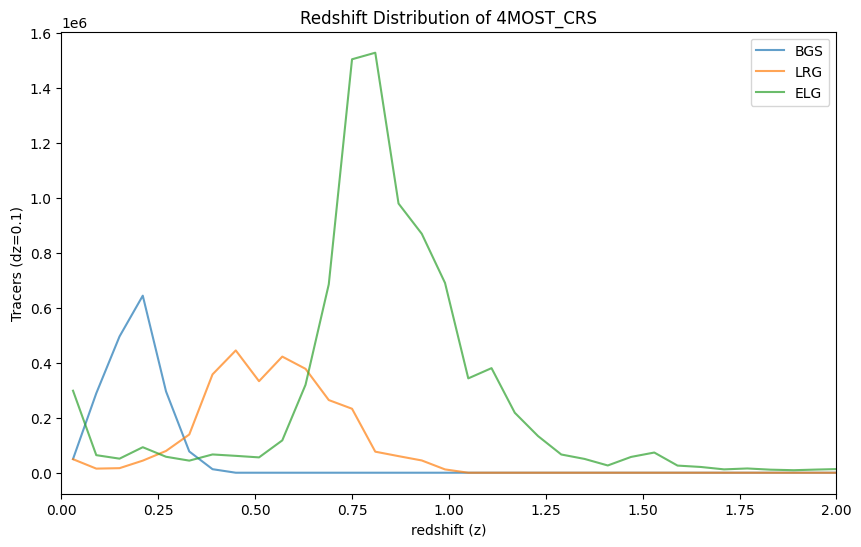

n_eff bgs: 0.06911086111111112
n_eff lrg: 0.11007030555555555
n_eff elg: 0.33191191666666664


In [78]:
# redshift information:
zmin =  data['ZMIN']
zmax =  data['ZMAX']
bin_edges = np.concatenate((zmin, zmax[-1:]))
bin_widths = zmax - zmin
bin_centers = bin_widths/2 + zmin 
n_bins = len(bin_centers)

# Plotting the all data points.
spec_types = ['BGS', 'LRG', 'ELG']
data_spec = {}
plt.figure(figsize=(10, 6))
for types in spec_types:   
    # Extract the data for the current type
    data_spec[types] = data[types]
    # Ploting the data points
    plt.plot(bin_centers, data_spec[types], alpha=0.7, label = types)
plt.ylabel('Tracers (dz=0.1)')
plt.xlabel('redshift (z)')
plt.xlim(0, 2.0)
plt.legend()
plt.title('Redshift Distribution of 4MOST_CRS')
plt.show()         

# Effective number density of each type of galaxy provide by the SV data
ngal_bgs = (data['BGS'].sum())/(_4most_crs_sky*3600)
ngal_lrg = (data['LRG'].sum())/(_4most_crs_sky*3600)
ngal_elg = (data['ELG'].sum())/(_4most_crs_sky*3600)
print(f'n_eff bgs: {ngal_bgs}')
print(f'n_eff lrg: {ngal_lrg}')
print(f'n_eff elg: {ngal_elg}')

### Interpolating and normalizing the distribution


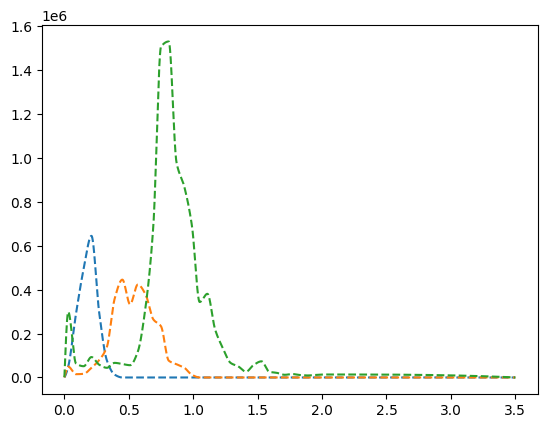

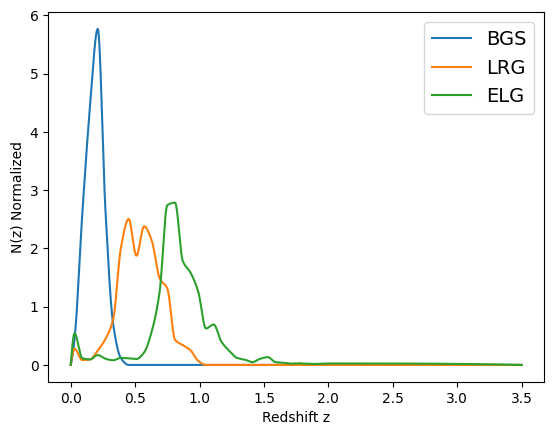

In [79]:
#Constructing the center of the bins and the data points
# Adding the zero dot to don't have problems with the interpolation
bins_centers = np.insert(bin_centers, 0, 0.0)
n_bgs_z = np.insert(data_spec['BGS'], 0, 0.0)
n_lrg_z = np.insert(data_spec['LRG'], 0, 0.0)
n_elg_z = np.insert(data_spec['ELG'], 0, 0.0)
# Adding the last point to don't have problems with the interpolation
bins_centers = np.append(bins_centers, z[-1])
n_bgs_z = np.append(n_bgs_z, 0.0)
n_lrg_z = np.append(n_lrg_z, 0.0)
n_elg_z = np.append(n_elg_z, 0.0)

# Interpolating the data points
n_bgs_interp = PchipInterpolator(bins_centers, n_bgs_z)
n_lrg_interp = PchipInterpolator(bins_centers, n_lrg_z)
n_elg_interp = PchipInterpolator(bins_centers, n_elg_z)
n_bgs_z = n_bgs_interp(z)
n_lrg_z = n_lrg_interp(z)
n_elg_z = n_elg_interp(z)

# Plotting the interpolated functions
plt.plot(z, n_bgs_z, color = 'C0', linestyle = '--')
plt.plot(z, n_lrg_z, color = 'C1', linestyle = '--')
plt.plot(z, n_elg_z, color = 'C2', linestyle = '--')
plt.show()


# Normalizing the interpolated function
area = np.trapz(n_bgs_z, z)
n_bgs_z = n_bgs_z / area
area = np.trapz(n_lrg_z, z)
n_lrg_z = n_lrg_z / area
area = np.trapz(n_elg_z, z)
n_elg_z = n_elg_z / area

# Plotting the normalized N(z)
plt.plot(z, n_bgs_z, color = 'C0', label = 'BGS')
plt.plot(z, n_lrg_z, color = 'C1', label = 'LRG')
plt.plot(z, n_elg_z, color = 'C2', label = 'ELG')
plt.legend(fontsize = 14)
plt.xlabel("Redshift z")
plt.ylabel("N(z) Normalized")
plt.show()

np.savetxt('./auxiliar_files/bgs_normalized.txt', n_bgs_z)
np.savetxt('./auxiliar_files/lrg_normalized.txt', n_lrg_z)
np.savetxt('./auxiliar_files/elg_normalized.txt', n_elg_z)

## **The next Cells contain all the information needed to binned the distribution and get the bias and ngal per bin and other additional info's**


#### binning function:


In [80]:
def binnning_distribution(type, z_begin, z_stop, bin, dndz, n_eff):
    """
    Function to bin the distribution of the galaxies in redshift bins.
    """
    # Color map for the plots
    color = {'bgs': 'C0', 'lrg': 'C1', 'elg': 'C2', 'qso': 'C3'}
    # Create the bins
    bin_edges = np.arange(z_begin, z_stop+bin, bin)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
    
    # List to store the number of galaxies in each bin
    n_gal = []
    # List to store the binned dNdz
    dndz_binned_normalize = []
    for i in range(len(bin_centers)):
        # Select the galaxies in the bin
        start = bin_edges[i]
        end = bin_edges[i+1]
        mask = (z >= start) & (z < end)
        # Binning the normalize distribution
        dndz_binned = np.where(mask, dndz, 0.0)
        # Compute the number of galaxies in the bin
        n_gal.append(np.trapz(dndz_binned, z)*n_eff)
        # Normalize the binned distribution
        dndz_binned_norm = dndz_binned/np.trapz(dndz_binned, z) 
        # Append the binned dNdz to the list and plot it
        plt.plot(z, dndz_binned, label=f'spec{i}', color=color[type])
        dndz_binned_normalize.append(dndz_binned_norm)
    
    np.savetxt(f'./binned_distribution/desi_bgs_{bin}_binned_distribution_EDR.txt', np.array(dndz_binned))
    plt.title('dNdz for DESI BGS EDR binned (not normalized)')
    plt.xlabel('z')
    plt.ylabel('dNdz')
    plt.legend()
    plt.show()

    # Calculate the bias for the DESI BGS
    a = 1/(1+bin_centers)
    factor = {'bgs': 1.34, 'lrg': 1.7, 'elg': 0.84, 'qso': 1.1}
    bias = factor[type]/cosmo.growth_factor(a)
    sigma_z = 0.0005*(1+bin_centers)
    delta_z = 0.0002*(1+bin_centers)
    # Print the information about the binned dNdz's
    print(f'bin_edges {type}: {list(bin_edges)}')
    print(f'bin_centers {type}: {list(bin_centers)}')
    print(f'n_bins {type}: {len(bin_centers)}')
    print(f'sigma_z {type}: {sigma_z}')
    print(f'delta_z {type}: {delta_z}')
    print(f'bias {type}: {list(bias)}')
    print(f'ngal {type}: {n_gal}')

# BGS


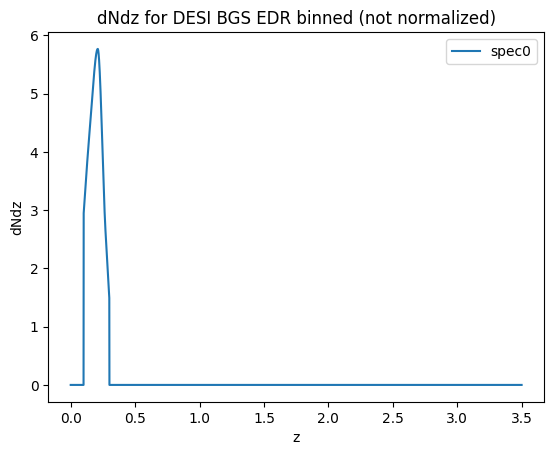

bin_edges bgs: [0.1, 0.30000000000000004]
bin_centers bgs: [0.2]
n_bins bgs: 1
sigma_z bgs: [0.0006]
delta_z bgs: [0.00024]
bias bgs: [1.4961698190993642]
ngal bgs: [0.05701783663852517]


In [91]:
# the BGS distribution is already normalized
dndz_desi_bgs_normalized = np.loadtxt('./auxiliar_files/bgs_normalized.txt')

# Defining the binning configuration for the dNdz's for DESI BGS
type_ = 'bgs'
bin_width = 0.2
z_start = 0.1
z_end = 0.3
n_eff = ngal_bgs
binnning_distribution(type_, z_start, z_end, bin_width, dndz_desi_bgs_normalized, n_eff)


# LRG


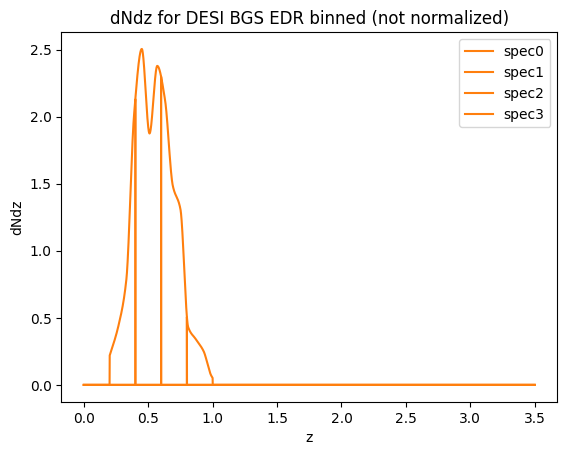

bin_edges lrg: [0.2, 0.4, 0.6000000000000001, 0.8, 1.0]
bin_centers lrg: [0.30000000000000004, 0.5, 0.7000000000000001, 0.9]
n_bins lrg: 4
sigma_z lrg: [0.00065 0.00075 0.00085 0.00095]
delta_z lrg: [0.00026 0.0003  0.00034 0.00038]
bias lrg: [2.004662762019507, 2.229404841505434, 2.466126835293615, 2.711498375292241]
ngal lrg: [0.01782765770554499, 0.04925806604451051, 0.03367404866845838, 0.006082311114274276]


In [87]:
# the LRG distribution is already normalized
dndz_desi_lrg_normalized = np.loadtxt('./auxiliar_files/lrg_normalized.txt')

# Defining the binning configuration for the dNdz's for DESI LRG
type_ = 'lrg'
bin_width = 0.2
z_start = 0.2
z_end = 1.0
n_eff = ngal_lrg
binnning_distribution(type_, z_start, z_end, bin_width, dndz_desi_lrg_normalized, n_eff)

# ELG


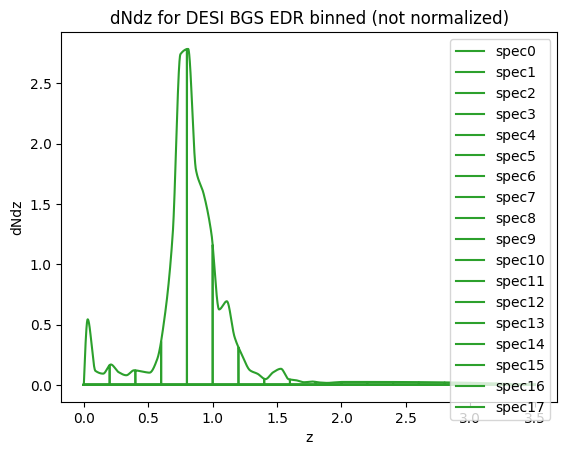

bin_edges elg: [0.0, 0.2, 0.4, 0.6000000000000001, 0.8, 1.0, 1.2000000000000002, 1.4000000000000001, 1.6, 1.8, 2.0, 2.2, 2.4000000000000004, 2.6, 2.8000000000000003, 3.0, 3.2, 3.4000000000000004, 3.6]
bin_centers elg: [0.1, 0.30000000000000004, 0.5, 0.7000000000000001, 0.9, 1.1, 1.3000000000000003, 1.5, 1.7000000000000002, 1.9, 2.1, 2.3000000000000003, 2.5, 2.7, 2.9000000000000004, 3.1, 3.3000000000000003, 3.5]
n_bins elg: 18
sigma_z elg: [0.00055 0.00065 0.00075 0.00085 0.00095 0.00105 0.00115 0.00125 0.00135
 0.00145 0.00155 0.00165 0.00175 0.00185 0.00195 0.00205 0.00215 0.00225]
delta_z elg: [0.00022 0.00026 0.0003  0.00034 0.00038 0.00042 0.00046 0.0005  0.00054
 0.00058 0.00062 0.00066 0.0007  0.00074 0.00078 0.00082 0.00086 0.0009 ]
bias elg: [0.8876001926501569, 0.9905392471155211, 1.1015882746262144, 1.218556789203904, 1.3397991972032248, 1.4641308471264376, 1.5907140124364125, 1.7189580016449162, 1.8484439439418332, 1.9788718460212391, 2.110023911976069, 2.2417398660828267, 2

In [ ]:
# the ELG distribution is already normalized
dndz_desi_elg_normalized = np.loadtxt('./auxiliar_files/elg_normalized.txt')

# Defining the binning configuration for the dNdz's for DESI ELG
type_ = 'elg'
bin_width = 0.2
z_start = 0.6
z_end = 1.2
n_eff = ngal_elg
binnning_distribution(type_, z_start, z_end, bin_width, dndz_desi_elg_normalized, n_eff)